In [1]:
#Pkg.add("Distributions")
using Distributions

mu = [10 20 30 40]';
Lambda =
[1.0 0 0
 0 1.0 0
 0 0 1.0
 0.5 0.5 0];
Psi = diagm([0.1, 0.2, 0.3, 0.4]);
d1 = MvNormal([0,0,0],ones(3));
X = zeros(50,4);
for i=1:50
f = rand(d1,1);
d2 = MvNormal(vec(mu+ Lambda*f),Psi);
x = rand(d2,1);
X[i,:] = x';
end
X

50×4 Array{Float64,2}:
 11.8342   20.5978  30.8086  41.4171
 10.6987   21.8422  32.0769  41.2695
 10.4924   21.202   30.6792  40.4241
  9.69625  18.7289  30.7595  39.9493
 10.1585   20.7698  28.6737  39.08  
  9.02372  20.8617  29.1288  39.8561
 10.224    18.4453  29.5575  39.1574
  9.35707  20.2546  29.7534  39.2309
 10.7427   19.7685  29.9169  39.9085
  8.5487   21.6946  29.4852  40.004 
  9.9524   20.6222  29.6129  40.5888
  8.22279  20.9229  28.7771  38.1357
  7.89777  17.8073  29.6034  38.4133
  ⋮                                 
  9.96123  18.7745  29.9192  39.9712
 11.505    20.0853  30.0778  40.7837
  9.88228  18.4037  32.2841  39.8371
  8.90957  19.8485  31.9808  40.5351
  8.33182  20.5547  30.3923  40.3823
 10.4465   20.2861  30.0579  39.5676
  8.35544  20.8412  30.7752  39.534 
 11.3365   21.5372  30.7286  41.0307
  9.5099   18.3416  31.5037  37.9532
 10.4488   19.2088  28.358   39.17  
  8.03035  21.5109  32.2283  38.5372
 10.1601   20.2442  29.8635  40.0345

In [2]:
function E_Step(X,mu,Lambda,Psi,k)
mu_f_by_x = (X - repmat(mu',size(X,1),1))*(Lambda'*inv(Lambda*Lambda' + Psi))';
Sig_f_by_x = eye(k) - Lambda'*inv(Lambda*Lambda' + Psi)*Lambda;
return mu_f_by_x,Sig_f_by_x;
end


E_Step (generic function with 1 method)

In [3]:
function M_Step(X,mu_f_by_x,Sig_f_by_x,k)
nrows, ncols = size(X);
#Computing mu
mu = mean(X,1)';
#Computing Lambda
Lambda_term1 = zeros(ncols,k);
Lambda_term2 = zeros(k,k);
for i=1:nrows
Lambda_term1 = Lambda_term1 + ((X[i,:] - mu)*mu_f_by_x[i,:]');
Lambda_term2 = Lambda_term2 + inv((mu_f_by_x[i,:]*mu_f_by_x[i,:]')+Sig_f_by_x);
end
Lambda = Lambda_term1*Lambda_term2;
#Computing Psi
Phi = zeros(ncols,ncols);
for i=1:nrows
Phi = Phi + (X[i,:]*X[i,:]' - X[i,:]*mu_f_by_x[i,:]'*Lambda' - Lambda*mu_f_by_x[i,:]*X[i,:]' + Lambda*(mu_f_by_x[i,:]*mu_f_by_x[i,:]'+Sig_f_by_x)*Lambda')
end
Psi = diagm(diag(Phi./nrows));
return mu, Lambda, Psi
end
function compute_llh(X,mu,Lambda,Psi)
llh = 0;
for i=1:size(X,1)
llh = llh + log(pdf(MvNormal(vec(mu),(Lambda*Lambda')+Psi),X[i,:]));
end
return llh;
end

compute_llh (generic function with 1 method)

In [4]:
function fa_em(X,k)
max_Iter = 100;
eps = 0.0001;
llh = -Inf*ones(max_Iter+1);
mu = mean(X,1)';
Lambda = rand(size(X,2),k);
Psi = diagm(rand(size(X,2)));
print(mu,"\n",Lambda,"\n",Psi,"\n");
llh[1] = compute_llh(X,mu,Lambda,Psi);
print(llh[1],"\n")
for i=1:max_Iter
print(i,"\n");
mu_f_by_x,Sig_f_by_x = E_Step(X,mu,Lambda,Psi,k);
mu_new, Lambda_new, Psi_new = M_Step(X,mu_f_by_x,Sig_f_by_x,k);
print(mu_new,"\n",Lambda_new,"\n",Psi_new,"\n");
llh[i+1] = compute_llh(X,mu_new,Lambda_new,Psi_new);
print(llh[i+1],"\n");
if(sum(abs.(mu_new-mu))<eps && sum(abs.(Lambda_new-Lambda))<eps && sum(abs.(Psi_new-Psi))<eps)
break;
end
mu = mu_new;
Lambda = Lambda_new;
Psi = Psi_new;
end
mu_f_by_x,Sig_f_by_x = E_Step(X,mu,Lambda,Psi,k);
return mu, Lambda, Psi, mu_f_by_x, Sig_f_by_x, llh;
end

fa_em (generic function with 1 method)

In [5]:
#Calling the EM approach for dataset X and 2 factors
mu, Lambda, Psi, mu_f_by_x, Sig_f_by_x, llh = fa_em(X,3)


[9.8195; 19.9924; 30.3568; 39.8279]
[0.232196 0.253332 0.800856; 0.929926 0.0929331 0.481564; 0.652869 0.148361 0.0228587; 0.984475 0.370435 0.566857]
[0.134403 0.0 0.0 0.0; 0.0 0.0854253 0.0 0.0; 0.0 0.0 0.865584 0.0; 0.0 0.0 0.0 0.885938]
-341.6802941272435
1
[9.8195; 19.9924; 30.3568; 39.8279]
[3257.27 4127.62 12142.5; 17011.0 1646.96 8303.64; 2152.93 473.935 -512.348; 6639.76 2579.19 7624.46]
[2.2455e8 0.0 0.0 0.0; 0.0 2.65826e8 0.0 0.0; 0.0 0.0 7.34785e6 0.0; 0.0 0.0 0.0 7.50014e7]
-2050.7584083522447
2
[9.8195; 19.9924; 30.3568; 39.8279]
[0.08835 0.0972119 0.357885; 0.263125 0.0432342 0.133082; 1.00257 0.220407 -0.208986; 0.313639 0.112383 0.25415]
[97.9068 0.0 0.0 0.0; 0.0 400.811 0.0 0.0; 0.0 0.0 923.326 0.0; 0.0 0.0 0.0 1587.0]
-803.720613796743
3
[9.8195; 19.9924; 30.3568; 39.8279]
[3.10468 3.57734 13.346; 1.89164 0.195773 0.350472; 3.48062 0.545128 -1.69268; 2.45272 1.7338 5.80091]
[297.92 0.0 0.0 0.0; 0.0 404.52 0.0 0.0; 0.0 0.0 938.108 0.0; 0.0 0.0 0.0 1629.52]
-846.328399

[4169.75 0.0 0.0 0.0; 0.0 2909.75 0.0 0.0; 0.0 0.0 3243.01 0.0; 0.0 0.0 0.0 2887.1]
-1834.1811549830552
48
[9.8195; 19.9924; 30.3568; 39.8279]
[5.75673e5 2.06792e5 6.15924e5; 4.05234e5 1.16913e5 3.00884e5; 1.46636e5 27440.5 39886.0; 4.94016e5 1.6344e5 463615.0]
[5387.73 0.0 0.0 0.0; 0.0 3001.37 0.0 0.0; 0.0 0.0 2958.54 0.0; 0.0 0.0 0.0 4253.66]
-1879.149805678583
49
[9.8195; 19.9924; 30.3568; 39.8279]
[99850.8 48784.6 1.66666e5; 1.058e5 19546.5 27730.0; 60079.5 -4574.53 -57008.5; 1.00501e5 33369.2 94862.7]
[1501.26 0.0 0.0 0.0; 0.0 1475.47 0.0 0.0; 0.0 0.0 3218.77 0.0; 0.0 0.0 0.0 1857.09]
-1771.9389286532503
50
[9.8195; 19.9924; 30.3568; 39.8279]
[2.97483e5 140022.0 4.71895e5; 2.21108e5 41911.5 62854.6; 69600.0 -6219.53 -70286.5; 2.4295e5 86729.9 2.57423e5]
[9284.48 0.0 0.0 0.0; 0.0 4391.88 0.0 0.0; 0.0 0.0 3010.11 0.0; 0.0 0.0 0.0 4756.72]
-1887.5768814226096
51
[9.8195; 19.9924; 30.3568; 39.8279]
[2.42858e5 1.0478e5 3.41108e5; 2.05269e5 48780.2 104055.0; 95377.7 -2036.26 -66233.4; 2

[1020.5 0.0 0.0 0.0; 0.0 2060.09 0.0 0.0; 0.0 0.0 2507.71 0.0; 0.0 0.0 0.0 2162.8]
-1800.5933186415098
85
[9.8195; 19.9924; 30.3568; 39.8279]
[-3.83299e5 54609.0 4.80523e5; -3.96672e5 -17590.2 1.54441e5; -2.2872e5 -25729.9 16676.0; -3.66153e5 17200.4 2.97213e5]
[12605.1 0.0 0.0 0.0; 0.0 3136.72 0.0 0.0; 0.0 0.0 3706.31 0.0; 0.0 0.0 0.0 4852.46]
-1919.3475161446902
86
[9.8195; 19.9924; 30.3568; 39.8279]
[-196373.0 23154.2 223870.0; -4.74542e5 -15213.3 211703.0; -2.91765e5 -23902.0 62627.8; -3.2163e5 6130.46 2.19525e5]
[1557.06 0.0 0.0 0.0; 0.0 2676.81 0.0 0.0; 0.0 0.0 2935.61 0.0; 0.0 0.0 0.0 2591.33]
-1856.5131536248382
87
[9.8195; 19.9924; 30.3568; 39.8279]
[-327328.0 60099.1 4.72694e5; -3.05777e5 -17742.6 99690.5; -1.93405e5 -31214.7 -29691.2; -3.07315e5 19622.2 2.7346e5]
[7726.69 0.0 0.0 0.0; 0.0 1958.64 0.0 0.0; 0.0 0.0 3186.37 0.0; 0.0 0.0 0.0 3393.53]
-1897.2354517387928
88
[9.8195; 19.9924; 30.3568; 39.8279]
[-2.2757e5 38587.5 3.13849e5; -4.50715e5 -26179.2 146805.0; -2.18791e5 

([9.8195; 19.9924; 30.3568; 39.8279], [395083.0 98182.4 2.19832e5; -1.29613e5 24922.9 1.92598e5; -3.01318e5 -21607.1 78984.8; 1.43069e5 62898.0 2.06267e5], [2876.8 0.0 0.0 0.0; 0.0 2157.05 0.0 0.0; 0.0 0.0 2811.98 0.0; 0.0 0.0 0.0 2876.37], [-0.000602964 0.00470854 -0.00101051; -0.000297956 0.00229964 -0.000487816; … ; 0.00036811 -0.00291646 0.000631309; 0.000419066 -0.00325827 0.000704043], [0.0118638 -0.0924189 0.0199514; -0.0924189 0.719945 -0.155422; 0.0199514 -0.155422 0.0335524], [-341.68, -2050.76, -803.721, -846.328, -1023.66, -1017.97, -1107.07, -1083.68, -1151.13, -1135.71  …  -1921.42, -1759.88, -1853.01, -1809.96, -1875.81, -1805.51, -1894.83, -1832.81, -1912.22, -1883.15])

In [7]:
mu

4×1 Array{Float64,2}:
  9.8195
 19.9924
 30.3568
 39.8279

In [9]:
Lambda

4×3 Array{Float64,2}:
 395083.0         98182.4      2.19832e5
     -1.29613e5   24922.9      1.92598e5
     -3.01318e5  -21607.1  78984.8      
      1.43069e5   62898.0      2.06267e5

In [10]:
Psi

4×4 Array{Float64,2}:
 2876.8     0.0      0.0      0.0 
    0.0  2157.05     0.0      0.0 
    0.0     0.0   2811.98     0.0 
    0.0     0.0      0.0   2876.37

In [17]:
llh

101-element Array{Float64,1}:
  -341.68 
 -2050.76 
  -803.721
  -846.328
 -1023.66 
 -1017.97 
 -1107.07 
 -1083.68 
 -1151.13 
 -1135.71 
 -1189.8  
 -1182.54 
 -1227.18 
     ⋮    
 -2052.9  
 -1673.1  
 -1921.42 
 -1759.88 
 -1853.01 
 -1809.96 
 -1875.81 
 -1805.51 
 -1894.83 
 -1832.81 
 -1912.22 
 -1883.15 

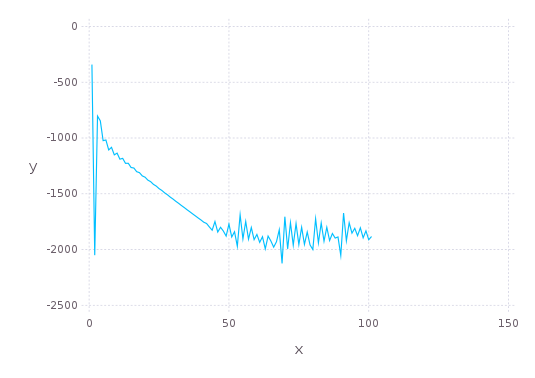

In [6]:
using Gadfly, Cairo, Fontconfig
#plot the log-likelihood
plot(x=collect(1:1:101), y=llh,Geom.line)

In [ ]:
### For k = 2 ###

In [11]:
mu, Lambda, Psi, mu_f_by_x, Sig_f_by_x, llh = fa_em(X,2)

[9.8195; 19.9924; 30.3568; 39.8279]
[0.947504 0.203326; 0.748321 0.335209; 0.738288 0.44953; 0.0648133 0.755094]
[0.914696 0.0 0.0 0.0; 0.0 0.985151 0.0 0.0; 0.0 0.0 0.886963 0.0; 0.0 0.0 0.0 0.835965]
-309.1604388661933
1
[9.8195; 19.9924; 30.3568; 39.8279]
[2318.62 1158.02; 1307.44 1005.58; 1643.32 1288.18; 1472.62 1583.49]
[3.94538e6 0.0 0.0 0.0; 0.0 1.68578e6 0.0 0.0; 0.0 0.0 2.70946e6 0.0; 0.0 0.0 0.0 3.05421e6]
-1717.884195111248
2
[9.8195; 19.9924; 30.3568; 39.8279]
[2.51062 1.57771; 2.39875 1.96796; 2.09053 1.73111; 2.40416 1.87644]
[99.101 0.0 0.0 0.0; 0.0 402.11 0.0 0.0; 0.0 0.0 923.875 0.0; 0.0 0.0 0.0 1588.22]
-807.0076306791051
3
[9.8195; 19.9924; 30.3568; 39.8279]
[91.2607 57.3607; 13.1381 11.5892; 1.50793 2.6518; 44.465 29.2261]
[10421.9 0.0 0.0 0.0; 0.0 673.985 0.0 0.0; 0.0 0.0 931.328 0.0; 0.0 0.0 0.0 4102.41]
-986.6876187965773
4
[9.8195; 19.9924; 30.3568; 39.8279]
[43.498 26.4209; 58.9132 50.9595; 8.70984 12.2058; 44.8188 32.4791]
[897.583 0.0 0.0 0.0; 0.0 2312.9 0.0

LoadError: [91mBase.LinAlg.PosDefException(3)[39m

In [12]:
mu

4×1 Array{Float64,2}:
  9.8195
 19.9924
 30.3568
 39.8279

In [13]:
Lambda

4×3 Array{Float64,2}:
 395083.0         98182.4      2.19832e5
     -1.29613e5   24922.9      1.92598e5
     -3.01318e5  -21607.1  78984.8      
      1.43069e5   62898.0      2.06267e5

In [14]:
Psi

4×4 Array{Float64,2}:
 2876.8     0.0      0.0      0.0 
    0.0  2157.05     0.0      0.0 
    0.0     0.0   2811.98     0.0 
    0.0     0.0      0.0   2876.37

In [16]:
llh

101-element Array{Float64,1}:
  -341.68 
 -2050.76 
  -803.721
  -846.328
 -1023.66 
 -1017.97 
 -1107.07 
 -1083.68 
 -1151.13 
 -1135.71 
 -1189.8  
 -1182.54 
 -1227.18 
     ⋮    
 -2052.9  
 -1673.1  
 -1921.42 
 -1759.88 
 -1853.01 
 -1809.96 
 -1875.81 
 -1805.51 
 -1894.83 
 -1832.81 
 -1912.22 
 -1883.15 

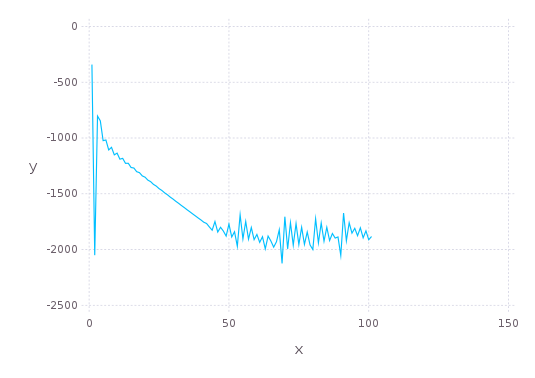

In [15]:
using Gadfly, Cairo, Fontconfig
#plot the log-likelihood
plot(x=collect(1:1:101), y=llh,Geom.line)